<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png?sfvrsn=764583a6_0' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

In [1]:
# import the packages
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('ASG1').getOrCreate()

### Step 1: Problem Statement Formulation

In [2]:
# load and explore data
df=spark.read.csv('./data/sg_flat_prices_mod.csv', header=True, inferSchema=True) # inferSchema auto detects data type

In [3]:
df.show()

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  465|ANG MO KIO AVE 10|    04 TO 06|          68.0|New Generation|

In [4]:
# value based problem statement

In [5]:
# Build a simple machine learning model to predict the resale prices of any given HDB
# resale transaction.

### Step 2: Exploratory Data Analysis and Data Cleansing

In [6]:
# consider NaN Treatment

In [7]:
# Get a list of the data types for each column
col_types = df.dtypes

# Filter the list to only include numerical data types
num_cols = [col[0] for col in col_types if col[1] in ("int", "double")]

# Print the list of numeric columns
print(num_cols)

['year', 'month', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'resale_price']


In [8]:
# Filter the list to only include string data types
cat_cols = [col[0] for col in col_types if col[1] == "string"]

# Print the list of categorical columns
print(cat_cols)

['town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model']


In [9]:
# selected varables for the demonstration
df.select(num_cols).describe().show()

+-------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|summary|              year|             month|   floor_area_sqm|lease_commence_date|   remaining_lease|      resale_price|
+-------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|  count|             64247|             64247|            64197|              64247|             64247|             64247|
|   mean|2018.0262424704656| 6.779133656046197|97.77009984890256| 1993.6012420813422| 894.6413840334957|438943.70469516085|
| stddev|0.8146939469668695|3.2635673352950514|24.26994610142912| 12.465629502278013|149.62669792791093|153760.65294972394|
|    min|              2017|                 1|             31.0|               1966|               553|          150000.0|
|    max|              2019|                12|            249.0|               2016|              1160|         1205000.0|
+-------

In [10]:
df.select(df.columns).distinct() and df.select(df.columns).count()

64247

In [11]:
df.count()

64247

In [12]:
# how to show null count
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|   0|    0|   0|        0|    0|          0|           0|            50|         0|                  0|              0|           0|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+



In [13]:
grouped_data = df.groupBy("flat_type")
mean_floor_area_sqms = grouped_data.mean("floor_area_sqm")

In [14]:
df = df.join(mean_floor_area_sqms, on="flat_type", how="left")
from pyspark.sql.functions import when
df = df.withColumn("floor_area_sqm", when(df["floor_area_sqm"].isNull(), df["avg(floor_area_sqm)"]).otherwise(df["floor_area_sqm"]))

In [15]:
#Check for null values again
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+----+-----+----+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+-------------------+
|flat_type|year|month|town|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|avg(floor_area_sqm)|
+---------+----+-----+----+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+-------------------+
|        0|   0|    0|   0|    0|          0|           0|             0|         0|                  0|              0|           0|                  0|
+---------+----+-----+----+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+-------------------+



In [16]:
df.groupBy('flat_type').count().show()

+----------------+-----+
|       flat_type|count|
+----------------+-----+
|          3 ROOM|15589|
|          1 ROOM|   29|
|          4 ROOM|26592|
|          2 ROOM|  919|
|       EXECUTIVE| 5169|
|          5 ROOM|15916|
|MULTI-GENERATION|   33|
+----------------+-----+



In [17]:

# Remove rows where the "flat_type" column is "1 ROOM" or "MULTI-GENERATION"
df = df.filter(~df["flat_type"].isin(["1 ROOM", "MULTI-GENERATION"]))

In [18]:
df.groupBy('flat_type').count().show()

+---------+-----+
|flat_type|count|
+---------+-----+
|   3 ROOM|15589|
|   4 ROOM|26592|
|   2 ROOM|  919|
|EXECUTIVE| 5169|
|   5 ROOM|15916|
+---------+-----+



In [19]:
df.groupBy('flat_model').count().show(truncate = False)

+----------------------+-----+
|flat_model            |count|
+----------------------+-----+
|Apartment             |2627 |
|Premium Maisonette    |7    |
|Improved              |16042|
|Type S2               |63   |
|New Generation        |9068 |
|Improved-Maisonette   |13   |
|Model A-Maisonette    |110  |
|Maisonette            |1909 |
|Model A               |20743|
|DBSS                  |936  |
|Simplified            |2754 |
|Terrace               |38   |
|Adjoined flat         |119  |
|Type S1               |117  |
|Standard              |1802 |
|Premium Apartment     |6945 |
|Model A2              |885  |
|Premium Apartment Loft|7    |
+----------------------+-----+



In [20]:
df.groupBy('town').count().show(50, truncate = False)

+---------------+-----+
|town           |count|
+---------------+-----+
|QUEENSTOWN     |1708 |
|BEDOK          |3429 |
|CLEMENTI       |1403 |
|SERANGOON      |1327 |
|BUKIT PANJANG  |2384 |
|BUKIT TIMAH    |189  |
|YISHUN         |4314 |
|GEYLANG        |1554 |
|WOODLANDS      |4988 |
|BUKIT MERAH    |2549 |
|TOA PAYOH      |2184 |
|BISHAN         |1263 |
|PUNGGOL        |4013 |
|HOUGANG        |2982 |
|ANG MO KIO     |2917 |
|PASIR RIS      |1836 |
|SENGKANG       |4970 |
|KALLANG/WHAMPOA|1916 |
|BUKIT BATOK    |2451 |
|TAMPINES       |4071 |
|JURONG WEST    |4945 |
|JURONG EAST    |1446 |
|MARINE PARADE  |387  |
|CENTRAL AREA   |545  |
|SEMBAWANG      |1754 |
|CHOA CHU KANG  |2660 |
+---------------+-----+



In [21]:
from pyspark.sql import functions as F

# Group the data by town
grouped_data = df.groupBy("town")

# Compute the average resale price for each town
avg_resale_price = grouped_data.agg(F.mean("resale_price").alias("resale_price"))

# Sort the resulting DataFrame by average resale price
sorted_data = avg_resale_price.orderBy("resale_price", ascending=False)

# Show the results
sorted_data.show(50)


+---------------+------------------+
|           town|      resale_price|
+---------------+------------------+
|    BUKIT TIMAH| 714816.9735449735|
|         BISHAN| 643720.7957244655|
|   CENTRAL AREA| 623428.0220183487|
|    BUKIT MERAH| 568323.6060729699|
|     QUEENSTOWN| 554835.8535597189|
|  MARINE PARADE| 518115.9173126615|
|KALLANG/WHAMPOA|496043.73121085594|
|      TOA PAYOH| 494166.7532051282|
|      PASIR RIS| 492123.0871459695|
|      SERANGOON| 490769.0934438583|
|       TAMPINES| 473382.8806190125|
|       CLEMENTI| 469028.6115466857|
|        PUNGGOL| 453269.6137253925|
|       SENGKANG|433994.11826156947|
|        GEYLANG|430605.67181467183|
|        HOUGANG|429212.74610328645|
|  BUKIT PANJANG|428196.38632550335|
|    JURONG EAST| 416185.7745504841|
|     ANG MO KIO| 411547.1964346932|
|          BEDOK| 410944.0495771362|
|    JURONG WEST| 387879.4531122346|
|  CHOA CHU KANG|384960.08120300755|
|      SEMBAWANG| 378804.1880729761|
|    BUKIT BATOK| 377715.2757037944|
|

In [22]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define a window for the data, partitioned by town
window = Window.partitionBy("town")

# Group the data by town and model type
grouped_data = df.groupBy("town", "flat_type")

# Count the number of rows in each group
counts = grouped_data.agg(F.count("*").alias("count"))

counts.show()

+---------------+---------+-----+
|           town|flat_type|count|
+---------------+---------+-----+
|    BUKIT MERAH|   3 ROOM|  907|
|    JURONG EAST|   5 ROOM|  360|
|      SERANGOON|   3 ROOM|  283|
|   CENTRAL AREA|   2 ROOM|   16|
|          BEDOK|   3 ROOM| 1491|
|     QUEENSTOWN|   3 ROOM|  791|
|     ANG MO KIO|   4 ROOM|  777|
|    JURONG WEST|   3 ROOM|  947|
|  CHOA CHU KANG|   3 ROOM|  165|
|       TAMPINES|EXECUTIVE|  464|
|       SENGKANG|   3 ROOM|  330|
|    BUKIT MERAH|   5 ROOM|  581|
|KALLANG/WHAMPOA|EXECUTIVE|   42|
|      PASIR RIS|   2 ROOM|    2|
|        PUNGGOL|   3 ROOM|  295|
|       TAMPINES|   4 ROOM| 1584|
|        GEYLANG|   5 ROOM|  203|
|    JURONG EAST|   4 ROOM|  422|
|  CHOA CHU KANG|   4 ROOM| 1263|
|      PASIR RIS|EXECUTIVE|  511|
+---------------+---------+-----+
only showing top 20 rows



In [23]:
from pyspark.sql import functions as F

# Group the data by town
grouped_data = df.groupBy("storey_range")

# Compute the average resale price for each town
avg_resale_price = grouped_data.agg(F.mean("resale_price").alias("resale_price"))

# Sort the resulting DataFrame by average resale price
sorted_data = avg_resale_price.orderBy("resale_price", ascending=False)

# Show the results
sorted_data.show(50)


+------------+------------------+
|storey_range|      resale_price|
+------------+------------------+
|    43 TO 45|1037833.3333333334|
|    49 TO 51|1022814.6666666666|
|    46 TO 48|1018845.4545454546|
|    40 TO 42|       894045.9375|
|    37 TO 39| 845602.7674418605|
|    34 TO 36| 802757.8962962963|
|    31 TO 33| 800630.9291338583|
|    28 TO 30| 751391.7605177993|
|    25 TO 27| 666919.1401295896|
|    22 TO 24| 610122.5498092031|
|    19 TO 21| 591394.6781223805|
|    16 TO 18|514570.93940520444|
|    13 TO 15|472987.87508488825|
|    10 TO 12|438019.12078618666|
|    07 TO 09| 423331.7550947538|
|    04 TO 06| 411894.9576388235|
|    01 TO 03| 394287.5250354052|
+------------+------------------+



In [24]:


# filter the DataFrame to include only resale prices above 1 million
count_over1m = df.filter(df["resale_price"] > 1000000)

# count the number of rows in the filtered DataFrame
count_over1m = count_over1m.count()

# print the result
print("Number of resale prices above 1 million:", count_over1m)


Number of resale prices above 1 million: 154


In [25]:


# compute the approximate quantiles of the resale_price column
quantiles = df.approxQuantile("resale_price", [0.25, 0.75], 0.05)

# define the lower and upper bounds of the expected range
lower_bound = quantiles[0] - 1.5 * (quantiles[1] - quantiles[0])
upper_bound = quantiles[1] + 1.5 * (quantiles[1] - quantiles[0])

# filter the DataFrame to include only data points outside of the expected range
outliers = df.filter((df["resale_price"] < lower_bound) | (df["resale_price"] > upper_bound))

# print the number of outliers found
print("Number of outliers:", outliers.count())

# print the range of values for potential outliers
print("Outlier range:", lower_bound, "to", upper_bound)


Number of outliers: 3800
Outlier range: 80500.0 to 732500.0


### Step 3: Data Wrangling and Transformation

In [26]:
# consider categorical and numerical variable treatment and transformations

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer


stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in cat_cols]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in cat_cols]

ppl = Pipeline(stages= stage_string + stage_one_hot)
df = ppl.fit(df).transform(df)
df.show(5)



+---------+----+-----+----------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+-------------------+-------------------+------------------------+--------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+------------------+-------------------+--------------------+------------------+
|flat_type|year|month|      town|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|avg(floor_area_sqm)|town_string_encoded|flat_type_string_encoded|block_string_encoded|street_name_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|     block_one_hot|street_name_one_hot|storey_range_one_hot|flat_model_one_hot|
+---------+----+-----+----------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------

In [28]:
df.dtypes

[('flat_type', 'string'),
 ('year', 'int'),
 ('month', 'int'),
 ('town', 'string'),
 ('block', 'string'),
 ('street_name', 'string'),
 ('storey_range', 'string'),
 ('floor_area_sqm', 'double'),
 ('flat_model', 'string'),
 ('lease_commence_date', 'int'),
 ('remaining_lease', 'int'),
 ('resale_price', 'double'),
 ('avg(floor_area_sqm)', 'double'),
 ('town_string_encoded', 'double'),
 ('flat_type_string_encoded', 'double'),
 ('block_string_encoded', 'double'),
 ('street_name_string_encoded', 'double'),
 ('storey_range_string_encoded', 'double'),
 ('flat_model_string_encoded', 'double'),
 ('town_one_hot', 'vector'),
 ('flat_type_one_hot', 'vector'),
 ('block_one_hot', 'vector'),
 ('street_name_one_hot', 'vector'),
 ('storey_range_one_hot', 'vector'),
 ('flat_model_one_hot', 'vector')]

In [29]:
from pyspark.sql import functions as F

# Get a list of all the columns in the DataFrame

# Set the name of the target variable
target = 'resale_price'

# Loop through each column
for col in num_cols:
  # Skip the target variable
  if col == target:
    continue

  # Calculate the median and IQR of the column
  quantiles = df.approxQuantile(col, [0.25, 0.75], 0.25)
  median = quantiles[1]
  iqr = quantiles[1] - quantiles[0]

  # Create a new column that is the result of applying robust scaling to the column
  df = df.withColumn(
      f'scaled_{col}',
      (df[col] - median) / iqr
  )


In [30]:
df.dtypes

[('flat_type', 'string'),
 ('year', 'int'),
 ('month', 'int'),
 ('town', 'string'),
 ('block', 'string'),
 ('street_name', 'string'),
 ('storey_range', 'string'),
 ('floor_area_sqm', 'double'),
 ('flat_model', 'string'),
 ('lease_commence_date', 'int'),
 ('remaining_lease', 'int'),
 ('resale_price', 'double'),
 ('avg(floor_area_sqm)', 'double'),
 ('town_string_encoded', 'double'),
 ('flat_type_string_encoded', 'double'),
 ('block_string_encoded', 'double'),
 ('street_name_string_encoded', 'double'),
 ('storey_range_string_encoded', 'double'),
 ('flat_model_string_encoded', 'double'),
 ('town_one_hot', 'vector'),
 ('flat_type_one_hot', 'vector'),
 ('block_one_hot', 'vector'),
 ('street_name_one_hot', 'vector'),
 ('storey_range_one_hot', 'vector'),
 ('flat_model_one_hot', 'vector'),
 ('scaled_year', 'double'),
 ('scaled_month', 'double'),
 ('scaled_floor_area_sqm', 'double'),
 ('scaled_lease_commence_date', 'double'),
 ('scaled_remaining_lease', 'double')]

In [31]:
from pyspark.ml.feature import VectorAssembler
cols1 = ["scaled_year", "scaled_month", "scaled_floor_area_sqm", "scaled_lease_commence_date","scaled_remaining_lease","town_one_hot", "flat_type_one_hot", "block_one_hot",
         "street_name_one_hot", "storey_range_one_hot", "flat_model_one_hot"]
featureassembler=VectorAssembler(inputCols=cols1,outputCol="Xcols")

In [32]:
featureassembler

VectorAssembler_27f7279ff19a

In [33]:
output = featureassembler.transform(df)

In [34]:
output.show()

+---------+----+-----+----------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+-------------------+-------------------+------------------------+--------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+------------------+-------------------+--------------------+------------------+-----------+------------+---------------------+--------------------------+----------------------+--------------------+
|flat_type|year|month|      town|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|avg(floor_area_sqm)|town_string_encoded|flat_type_string_encoded|block_string_encoded|street_name_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|     block_one_hot|street_name_one_hot|storey_range_one_hot|flat_model_one_hot|scaled_year|scaled_month|

In [35]:
final_data = output.select("Xcols", "resale_price")

In [36]:
final_data.show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------+------------+
|Xcols                                                                                                                        |resale_price|
+-----------------------------------------------------------------------------------------------------------------------------+------------+
|(2993,[0,1,2,3,4,13,138,2424,2962,2977],[-1.0,-1.0,-0.9534883720930233,-0.74,-0.6985172981878089,1.0,1.0,1.0,1.0,1.0])       |232000.0    |
|(2993,[0,1,2,3,4,13,32,56,2440,2963,2978],[-1.0,-1.0,-0.8465116279069768,-0.76,-0.71334431630972,1.0,1.0,1.0,1.0,1.0,1.0])   |250000.0    |
|(2993,[0,1,2,3,4,13,32,166,2451,2963,2978],[-1.0,-1.0,-0.8465116279069768,-0.72,-0.6771004942339374,1.0,1.0,1.0,1.0,1.0,1.0])|262000.0    |
|(2993,[0,1,2,3,4,13,32,432,2424,2960,2978],[-1.0,-1.0,-0.8418604651162791,-0.72,-0.6836902800658978,1.0,1.0,1.0,1.0,1.0,1.0])|265000.0    |
|(2993,[0,1,2

In [37]:
# from pyspark.ml.feature import StandardScaler

# sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

In [38]:
# final_data = sScaler.fit(final_data).transform(final_data)

In [39]:
# final_data = final_data.select("Xcols_sscaled","resale_price")
# final_data.show(2, truncate = False)

### Step 4: Machine Learning Modelling

In [40]:

# Import the LinearRegression class
from pyspark.ml.regression import LinearRegression


# Split the data into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2])

# Create a LinearRegression instance
lr = LinearRegression(featuresCol='Xcols', labelCol='resale_price')

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Evaluate the model on the test data
test_results = lr_model.evaluate(test_data)
train_results = lr_model.evaluate(train_data)

In [41]:
# use code to show number of rows and columns,
# as well as a sample of 10 rows before heading into Machine Learning Modelling

### Step 5: Model Evaluation and Selection

In [42]:
train_results.predictions.show()

+--------------------+------------+------------------+
|               Xcols|resale_price|        prediction|
+--------------------+------------+------------------+
|(2993,[0,1,2,3,4,...|    281888.0|260644.92994446855|
|(2993,[0,1,2,3,4,...|    230000.0|253948.44620114856|
|(2993,[0,1,2,3,4,...|    345000.0|337572.17626472143|
|(2993,[0,1,2,3,4,...|    298000.0| 329027.0526806555|
|(2993,[0,1,2,3,4,...|    348000.0|351188.44022754335|
|(2993,[0,1,2,3,4,...|    330000.0|349773.20241346955|
|(2993,[0,1,2,3,4,...|    350000.0|357791.14523212845|
|(2993,[0,1,2,3,4,...|    345000.0|363072.39116137463|
|(2993,[0,1,2,3,4,...|    350000.0| 360448.9374103135|
|(2993,[0,1,2,3,4,...|    328000.0| 354614.4060499696|
|(2993,[0,1,2,3,4,...|    345000.0|368653.05073417304|
|(2993,[0,1,2,3,4,...|    330000.0| 358876.2467989819|
|(2993,[0,1,2,3,4,...|    327000.0| 328280.1957339132|
|(2993,[0,1,2,3,4,...|    348000.0| 377372.3661532765|
|(2993,[0,1,2,3,4,...|    330000.0|378301.56289618043|
|(2993,[0,

In [43]:
test_results.predictions.show()

+--------------------+------------+------------------+
|               Xcols|resale_price|        prediction|
+--------------------+------------+------------------+
|(2993,[0,1,2,3,4,...|    280000.0| 283082.2667207706|
|(2993,[0,1,2,3,4,...|    375000.0|348863.37452236295|
|(2993,[0,1,2,3,4,...|    328000.0| 339711.1317984944|
|(2993,[0,1,2,3,4,...|    330000.0| 316704.4731957804|
|(2993,[0,1,2,3,4,...|    312000.0|310007.98945246043|
|(2993,[0,1,2,3,4,...|    335000.0| 337202.4482965722|
|(2993,[0,1,2,3,4,...|    282000.0|  337300.862405656|
|(2993,[0,1,2,3,4,...|    343500.0|370981.93631958275|
|(2993,[0,1,2,3,4,...|    295000.0| 313591.6173210355|
|(2993,[0,1,2,3,4,...|    256000.0|258713.44807255978|
|(2993,[0,1,2,3,4,...|    235000.0|258221.22365773295|
|(2993,[0,1,2,3,4,...|    280000.0|  271520.412405638|
|(2993,[0,1,2,3,4,...|    225000.0| 228270.8497902276|
|(2993,[0,1,2,3,4,...|    318000.0| 333482.2541363351|
|(2993,[0,1,2,3,4,...|    310000.0| 330646.9268378196|
|(2993,[0,

In [44]:
# Print the MSE, MAE, and R2 values
print("MSE: %f" % train_results.meanSquaredError)
print("MAE: %f" % train_results.meanAbsoluteError)
print("R2: %f" % train_results.r2)

MSE: 1232128028.770508
MAE: 25901.168703
R2: 0.947745


In [45]:
# Print the MSE, MAE, and R2 values
print("MSE: %f" % test_results.meanSquaredError)
print("MAE: %f" % test_results.meanAbsoluteError)
print("R2: %f" % test_results.r2)

MSE: 1340571505.505783
MAE: 27403.636964
R2: 0.942954


In [46]:
pyspark_two_rows = test_data.limit(2)
pyspark_two_rows.show()

+--------------------+------------+
|               Xcols|resale_price|
+--------------------+------------+
|(2993,[0,1,2,3,4,...|    280000.0|
|(2993,[0,1,2,3,4,...|    375000.0|
+--------------------+------------+



In [47]:
lr_model.evaluate(pyspark_two_rows).predictions.show()

+--------------------+------------+------------------+
|               Xcols|resale_price|        prediction|
+--------------------+------------+------------------+
|(2993,[0,1,2,3,4,...|    280000.0| 283082.2667207706|
|(2993,[0,1,2,3,4,...|    375000.0|348863.37452236295|
+--------------------+------------+------------------+



### Step 6: Report

## Table of Contents
- [Problem Statement Formulation](#part1)
    - [Load and Explore the Data](#part2)
    - [Understand the Data](#part3)
    - [Formulate a Value Based Problem Statement](#part4)
    
    
- [Exploratory Data Analysis and Data Cleansing](#part5)
    - [Interesting Trends](#part6)
    - [Anomalies](#part7)
    - [Potential Errors](#part8)
    - [Missing Value Treatment](#part9)
    
    
- [Data Wrangling and Transformation](#part10)
    - [Categorical Data](#part11)
    - [Numerical Data](#part12)
    - [Others](#part13)
    
    
- [Machine Learning Modelling](#part14)
    - [Show Count of Rows and Columns](#part15)
    - [Sample of 10 Rows before Modelling](#part16)
    - [Build the Predictive Model](#part17)
    
    
- [Model Evaluation and Selection ](#part18)
    - [Utilize Model Metrics for Evaluation](#part19)
    
    
- [Summary and Further Improvements](#part20)
    - [Summarize your findings](#part21)
    - [Explain the possible further improvements ](#part22)

## <a id='part1'>Problem Statement Formulation</a>

### <a id='part2'>Load and Explore the Data</a>
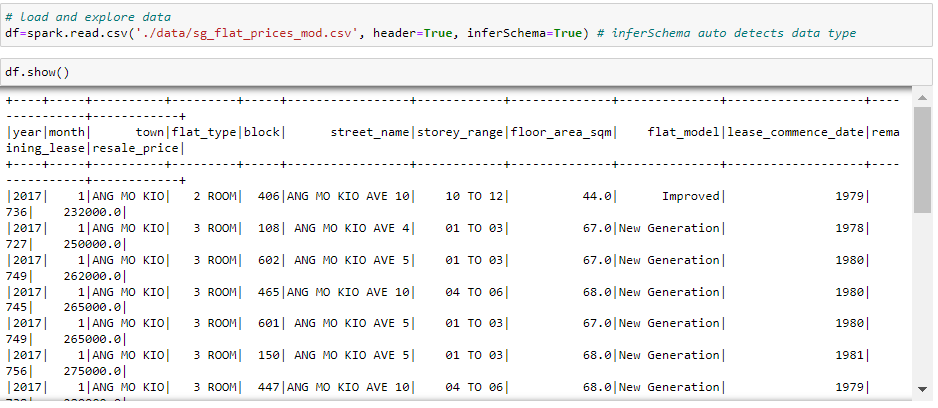

reading csv into pyspark data frame is a little different similar to pandas. using spark.read.csv we are able to read the csv into a pyspark data frame. With df.show() instead of df.head() for pandas, we display the first 20 rows of our dataset.

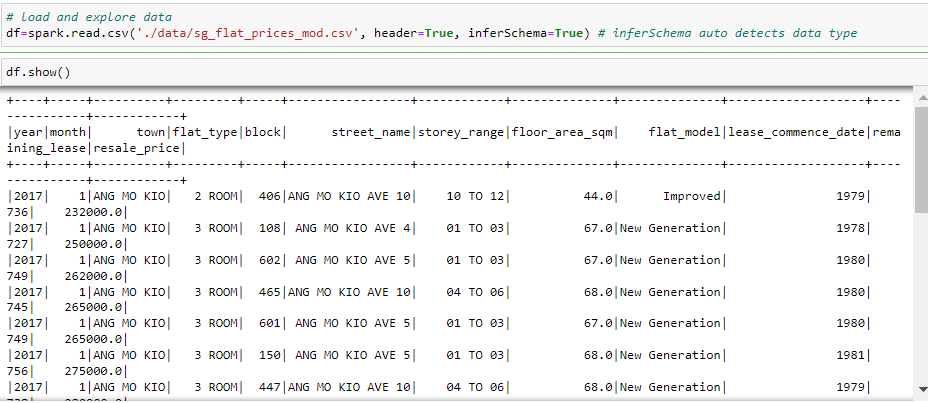

reading csv into pyspark data frame is a little different similar to pandas. using spark.read.csv we are able to read the csv into a pyspark data frame. With df.show() instead of df.head() for pandas, we display the first 20 rows of our dataset.

### <a id='part3'>Understand the Data</a>
There are a total of 12 columns including the target resale_price. the columns are as follows.

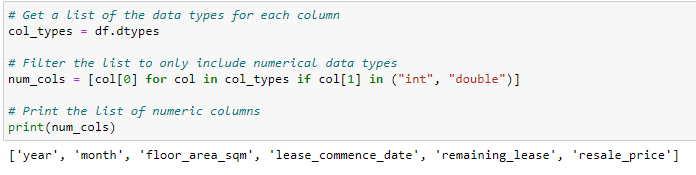

for numberical data, we have the following columns.
- year (year of sale)
- month (month of sale)
- floor_area_sqm (how much space is in the flat)
- lease_commence_date (start date of lease)
- remaining_lease (remaining years of lease)
- resale_price (price of the sale)

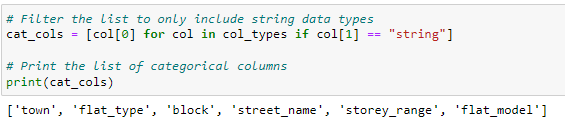

for categorical data, we have the follow

- town (town the flat is in i.e ang mo kio)
- flat_type (the type of flat it is i.e 2,3 room flat)
- block (the block of the hdbo, i.e blk 456)
- street_name (the name of the street i.e ang mo kio ave 10)
- storey_range (the range of floor it belongs to i.e 1-3 storey)
- flat_model (the model of the flat i.e New Generation)

### <a id='part4'>Formulate a Value Based Problem Statement</a>

The goal of this assignment is to use data preprocessing to build a simple linear regression machine learning model that accurately predicts the resale prices of HDB resale transactions. By doing so, we can provide valuable insights and predictions to stakeholders interested in buying or selling HDB properties. This model will help to inform decision-making and potentially even improve the efficiency of the HDB resale market.

### <a id='part5'>Exploratory Data Analysis and Data Cleansing</a>

### <a id='part6'>Interesting Trends</a>
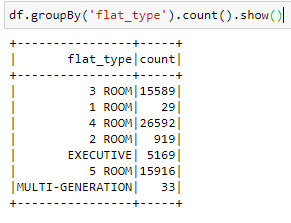

There are way more people buying 3, 4 and 5 rooms than the other flat types. 

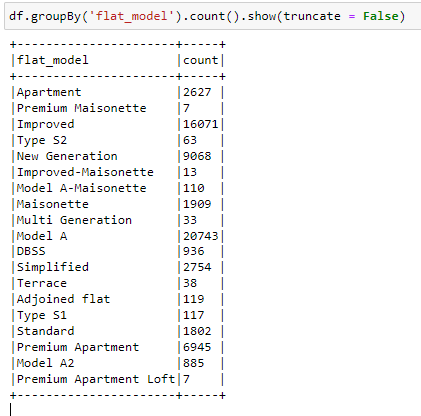

the most popular flat model is the model A and improved type

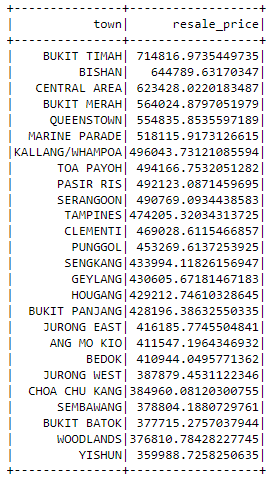

people are willing to pay more for flats in the bukit timah area

### <a id='part7'>Anomalies</a>
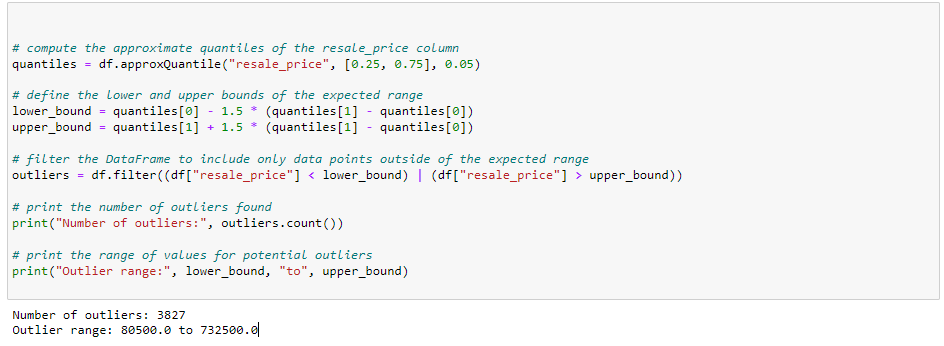
in the above code, we check for the number of outliers for resale_price and the range of price that the outliers fall outside of. There are 3827 outliers in the dataset for price, the outliers fall outside of the range 80500.0 to 732500.0.

Outliers can be considered a type of anomaly, they are data points that are significantly different from the majority of the data. Outliers exists for a variety of reasons , from error in the collection of data, to events in real life that to not comform to the expected outcome.

### <a id='part8'>Potential errors</a>
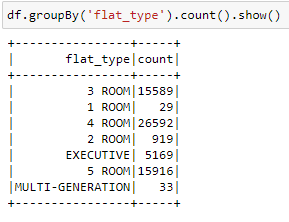

There are very few rows of data for multi gen and 1 room.

Having a small number of data points for a particular class in a dataset can make it difficult to build a machine learning model that can accurately classify data points into that class. In order for the model to be effective, we must feed it a diverse data with sufficient data points for each class. the model may struggle to learn the characteristics and patterns of that class, leading to poor performance. We may need to collect more datapoints for those classes or remove them.

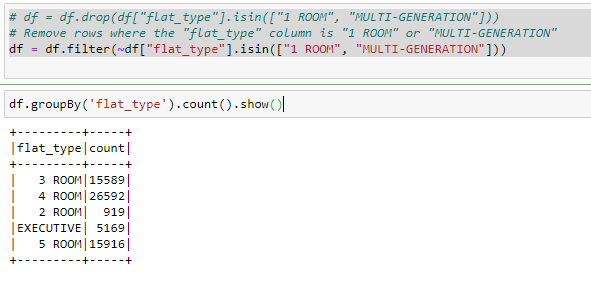
I decided to remove the classes that had very few data points.

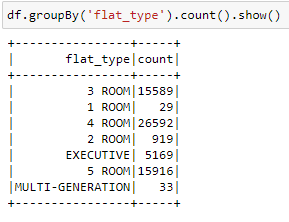



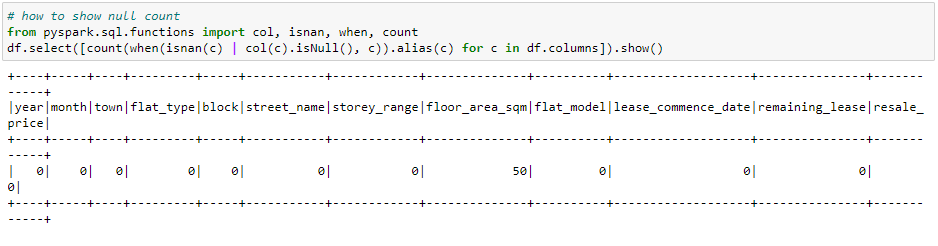
checking for null values in the data set, we found that there are 50 null values for the floor_area_sqm.

Missing values in a dataset can potentially be considered anomalies,they represent data points that are incomplete. This can be a problem because many machine learning algorithms require a complete dataset in order to function properly. Missing values can arise for a variety of reasons, including errors in data collection or entry, data that was not recorded or collected, or data that was intentionally withheld or removed. To address missing values in a dataset, it is often necessary to use imputation techniques to fill in the missing data or to remove any incomplete data points from the dataset. This can help to ensure that the dataset is complete and accurate, which can improve the performance of the machine learning model.

### <a id='part9'>Missing Value Treatment</a>
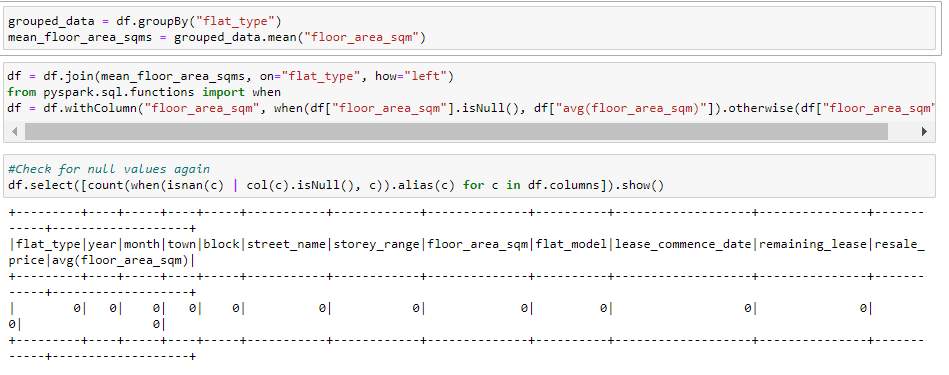

after we found there to be 50 missing values in floor_area_sqm previously, we replaced them with the mean of price by the flat_type classes.

we checked the dataframe again to see that the missing values have been successfully removed

## <a id='part10'>Data Wrangling and Transformation</a>

### <a id='part11'>Categorical Data</a>
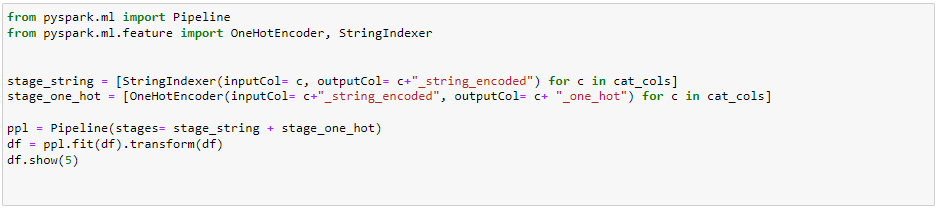

Pineline is a technique that efficiently executes transformations on the data. because we are doing two transformations, string indexer and one hot encoding, we use pipeline to apply them in stages.

The technique i used to encode my Categorical data is one hot encoding. It is a way of representing categorical data in numberical format. It turns it into a binary vector with possible values 0 and 1, depending if the value is present or not. 
In pyspark, to one hot encode we must first, use string indexer to map the classes to a numberical value, after we are able to convert that to generate our new one hot encoded columns.

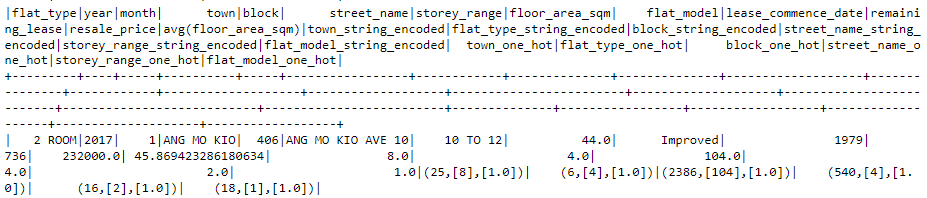

we can see that there are a bunch of new columns in our data frame, columns ending with our specified string_encoded are our string indexed columns, columns with the specified ohe_encoded are our one hot encoded columns.

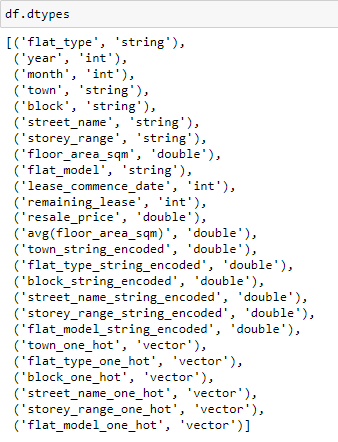

### <a id='part12'>Numerical Data</a>

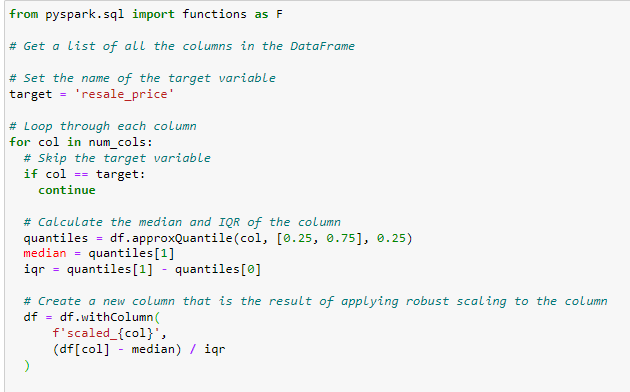

for numerical data, as observed, we have lots of outliers, to treat them we use robust scaling. Robust scaling is a method used for transforming numerical data by scaling the data to a standard range of values, while minimizing the influence of outlier values. the data is shifted so that the median is 0, and then it is scaled by the interquartile range.

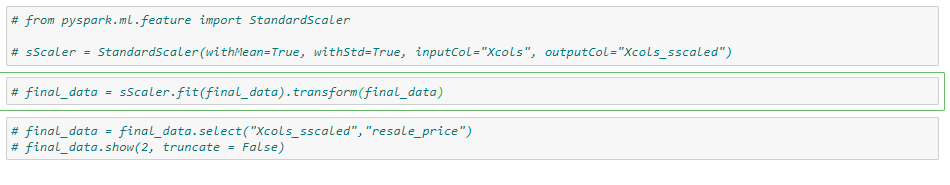

next, I tried applying standard scaling to the numerical features. It shifts the data so that it has a mean of 0 and a std of 1, then it is scaled by the std of the data. It is a common technique to make the data more ameanble to the model, most models are sensitive to the distribution of the data and standard scaling helps normalise the data. It is however sensitive to the presense of outliers, that is why i chose to apply robust scaling first.

### <a id='part13'>Others</a>

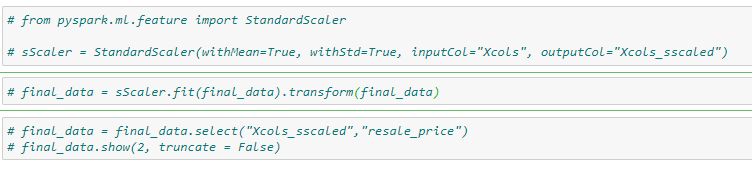

After trying standard scaling however, i achived a negative r2 score, suggesting a bad fit an worse than just predicting the mean. so I removed standard scaling.

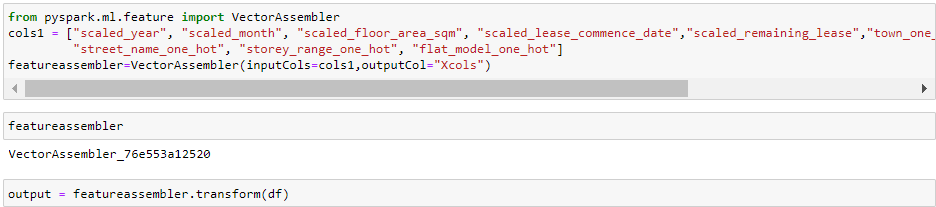
vectorising our features, output will be a Vector named Xcols, all the values of the features included in the inputCol will be combined into the vector, including onehotencoded vectors.

## <a id='part14'>Machine Learning Modelling</a>

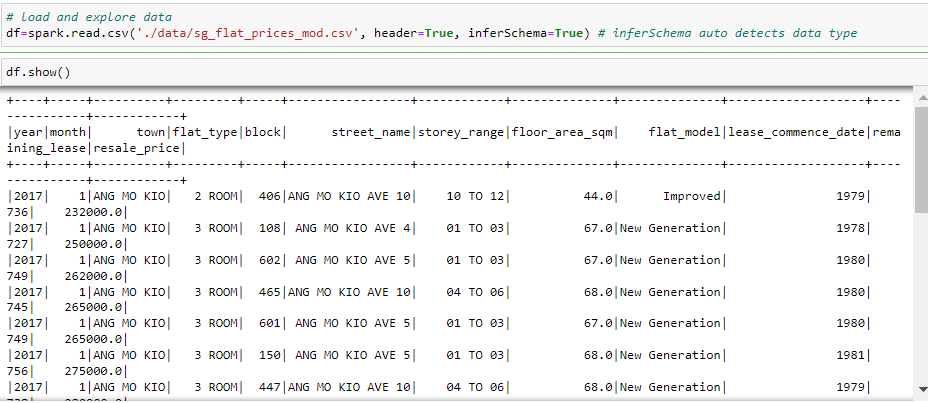

reading csv into pyspark data frame is a little different similar to pandas. using spark.read.csv we are able to read the csv into a pyspark data frame. With df.show() instead of df.head() for pandas, we display the first 20 rows of our dataset.

### <a id='part15'>Show Count of Rows and Columns</a>
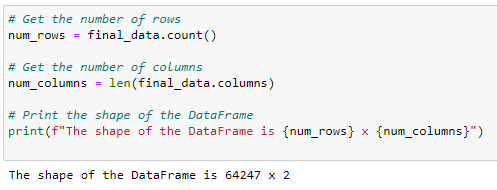
printing the count of rows and columns we can see that there are 64247 rows and 2 columns, there are only one feature besides the target because all the values of our other features has been vectorised.





### <a id='part16'>Sample of 10 Rows before Modelling</a>
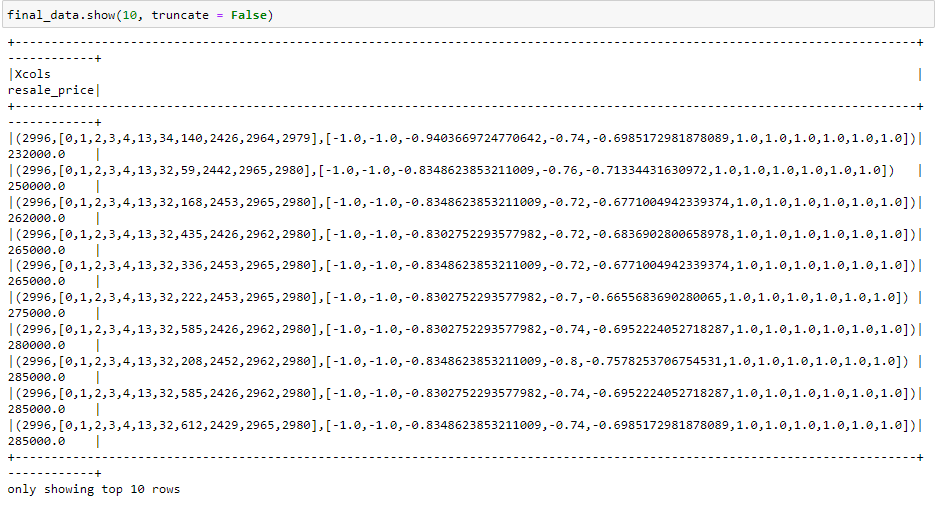

As we can see from the table above, Xcols holds all the values of our features, including one hot encoded vectors.

### <a id='part17'>Build the Predictive Model</a>

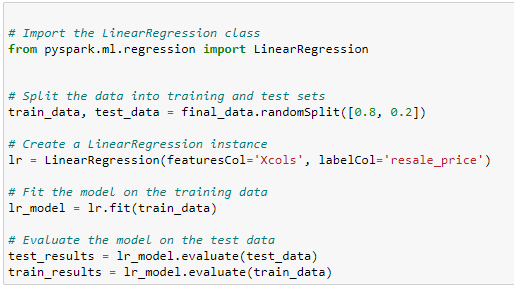

we first do a train test split of 80% train 20% test. next we specify the columns we want to use, in our case it is only the one vector Xcols, and then specify our target resale_price. we fit the model on the train data then evaluate both our train and test data.

## <a id='part18'>Model Evaluation and Selection</a>


### <a id='part19'>Utilize Model Metrics for Evaluation</a>
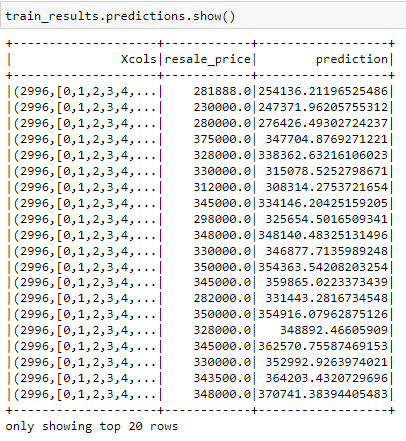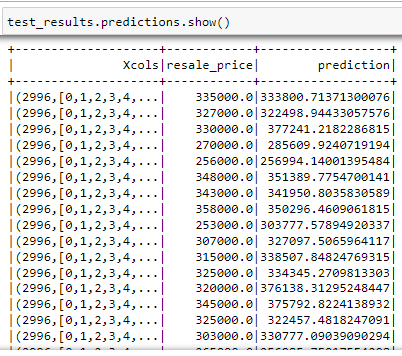

we print the train and test results for a quick check of prediction and actual.

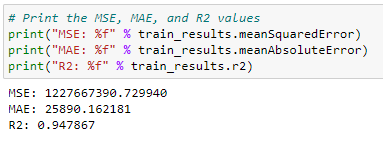
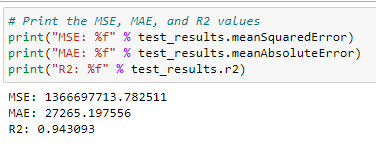
next we print the metrics to evaluate if our model is good or not.
we have quite high MSE and MAE, but we also have a very good R2 score.

MSE represents the distance between the predicted value and the actual value, squared. MSE is sensitive to outliers, a single large outlier can have a big impact on the value of MSE.

MAE represents the distance between the predicted value and the actual value, without taking the square or square root. Unlike MSE, MAE is not sensitive to outliers, since it only considers the magnitude of the error.

R2 is a measure of how well the regression model fits the data. the range of R2 is between 0 and 1 with numbers closer to 1 to be better suggesting a good fit. with 0.943 for our test data, the model is performing well.

### <a id='part20'>Summary and Further Improvements</a>

### <a id='part21'>Summarize your findings</a>

When dealing with missing values in a dataset, it is often better to replace the missing values with the mean of the values in the same column. but this may not always be the best way of doing it, the mean of a column may not accurately represent the values in the column. it may be better to replace the missing values with the mean groupby another column classes, this will return the mean of that class rather mean of all classes.

It is also important to observe the performance of a model after each transformation like standard scaling, in my case, my model performed worse and i removed that technique, it is also benificial to apply techniques like robust scaling to datasets that contains outliers, to enchance the models performace.

### <a id='part22'>Explain the possible further improvements</a>
Some improvements i could have done includes, trying out other scaling techniques like min-max, z-score normalisation, combining techniques like applying min-max after robust scaling could also have improved the performance of the model. I could also have tested on other regression algorithms like KNN-model, decision tree, random forest to compare performance of each regression algorithm.

### "Unlisted" Youtube Link to Video Presentation

In [48]:
# insert your link in this cell, you are allowed to comment it out
# youtube link: https://youtu.be/3-GdpNB_kIk